<a href="https://colab.research.google.com/github/hal-yu/datasci_6_anova/blob/main/datasci_6_anova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading Packages

In [1]:
!pip install ucimlrepo

In [20]:
import pandas as pd
import scipy.stats as stats
import re
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

In [13]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)

# data (as pandas dataframe)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets

/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


## Data Preparation

#### Variables of Interest

**Research Question:** How does the race and gender of the patient influence the duration of hospital stay?

**Independent Variable 1:** Race of patient

**Independent Variable 2:** Gender of patient

**Dependent Variable:** Time spent in hospital

Null Hypothesis: Gender and race has no effect on the duration of time spent in hospital.

Hypothesis: Gender and race has a significant effect on the duration of time spent in hospital.

In [38]:
# Loading Dataframe
df = pd.DataFrame(X)
df

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,No
1,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,...,No,No,Up,No,No,No,No,No,Ch,Yes
2,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,...,No,No,No,No,No,No,No,No,No,Yes
3,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,...,No,No,Up,No,No,No,No,No,Ch,Yes
4,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,...,No,No,Steady,No,No,No,No,No,Ch,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,[70-80),NaN,1,3,7,3,MC,NaN,...,No,No,Down,No,No,No,No,No,Ch,Yes
101762,AfricanAmerican,Female,[80-90),NaN,1,4,5,5,MC,NaN,...,No,No,Steady,No,No,No,No,No,No,Yes
101763,Caucasian,Male,[70-80),NaN,1,1,7,1,MC,NaN,...,No,No,Down,No,No,No,No,No,Ch,Yes
101764,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,...,No,No,Up,No,No,No,No,No,Ch,Yes


In [58]:
# Create new table
var = df[['race', 'gender', 'time_in_hospital']]
df = var.dropna()
df

,race,gender,time_in_hospital
0,Caucasian,Female,1
1,Caucasian,Female,3
2,AfricanAmerican,Female,2
3,Caucasian,Male,2
4,Caucasian,Male,1
...,...,...,...
101761,AfricanAmerican,Male,3
101762,AfricanAmerican,Female,5
101763,Caucasian,Male,1
101764,Caucasian,Female,10


## Assumption Checks


#### Normality

In [59]:
print('Main DV:', stats.shapiro(var['time_in_hospital']))

Main DV: ShapiroResult(statistic=0.8869192600250244, pvalue=0.0)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [60]:
groups = var.groupby(['race', 'gender'])

for (race_status, gender_status), group_df in groups:
    _, p_value = stats.shapiro(group_df['time_in_hospital'])

    print(f"Group ({race_status}, {gender_status}):")
    print(f"P-value from Shapiro-Wilk Test: {p_value}\n")


Group (AfricanAmerican, Female):
P-value from Shapiro-Wilk Test: 0.0

Group (AfricanAmerican, Male):
P-value from Shapiro-Wilk Test: 0.0

Group (Asian, Female):
P-value from Shapiro-Wilk Test: 9.520779367313894e-17

Group (Asian, Male):
P-value from Shapiro-Wilk Test: 4.219604476332644e-16

Group (Caucasian, Female):
P-value from Shapiro-Wilk Test: 0.0

Group (Caucasian, Male):
P-value from Shapiro-Wilk Test: 0.0

Group (Hispanic, Female):
P-value from Shapiro-Wilk Test: 9.368428169951816e-30

Group (Hispanic, Male):
P-value from Shapiro-Wilk Test: 5.67417287622373e-27

Group (Other, Female):
P-value from Shapiro-Wilk Test: 2.508905647524163e-24

Group (Other, Male):
P-value from Shapiro-Wilk Test: 1.5322922575434318e-23



/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ValueError: ignored

#### Interpretation

The Shapiro tests showed us that 6/10 combinations [Asian - Female, Asian - Male, Hispanic - Female, Hispanic - Male, other - Female, and Other - Male] are normally distributed with p-values > 0.05, which 4 combinations [African American - Female, African American - Male, Caucasian - Female, and Caucasian - Male] have p-values < 0.05, telling us that they are not normally distributed.

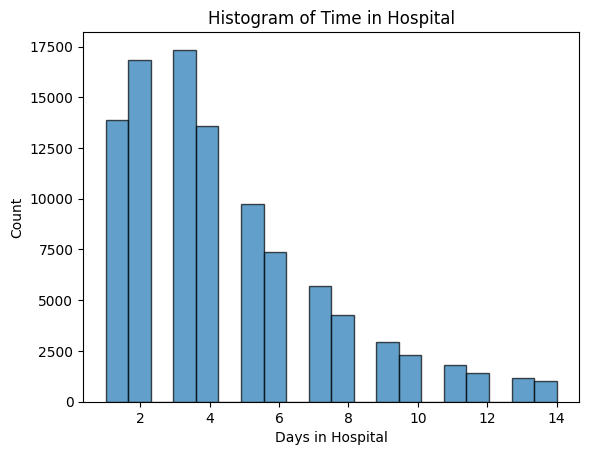

In [52]:
# Creating a Histogram
plt.hist(var['time_in_hospital'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Histogram of Time in Hospital')
plt.xlabel('Days in Hospital')
plt.ylabel('Count')
plt.show()

#### Homoscedasticity (equal Variances)

In [56]:
stats.levene(
    df['time_in_hospital'][df['race'] == 'AfricanAmerican'][df['gender'] == 'Female'],
    df['time_in_hospital'][df['race'] == 'AfricanAmerican'][df['gender'] == 'Male'],
    df['time_in_hospital'][df['race'] == 'Asian'][df['gender'] == 'Female'],
    df['time_in_hospital'][df['race'] == 'Asian'][df['gender'] == 'Male'],
    df['time_in_hospital'][df['race'] == 'Caucasian'][df['gender'] == 'Female'],
    df['time_in_hospital'][df['race'] == 'Caucasian'][df['gender'] == 'Male'],
    df['time_in_hospital'][df['race'] == 'Hispanic'][df['gender'] == 'Female'],
    df['time_in_hospital'][df['race'] == 'Hispanic'][df['gender'] == 'Male'],
    df['time_in_hospital'][df['race'] == 'Other'][df['gender'] == 'Female'],
    df['time_in_hospital'][df['race'] == 'Other'][df['gender'] == 'Male'],
)

LeveneResult(statistic=4.212648053226347, pvalue=1.8106820990342793e-05)

##### Interpretation
The Levene Test showed a p-value of 1.810682^-5, which is less than 0.05. This means that the variance is unequal.

## ANOVA

In [70]:
df = df.dropna(subset=["gender"])

In [71]:
model = ols('time_in_hospital ~ C(race) * C(gender)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                          sum_sq       df          F        PR(>F)
C(race)               541.291144      4.0  15.189971  2.025732e-12
C(gender)             707.448149      1.0  79.410993  5.127034e-19
C(race):C(gender)      94.442648      4.0   2.650295  3.143751e-02
Residual           886254.590879  99482.0        NaN           NaN


#### Interpretation

Race has a p-value of 2.0257^-12, which is less than the significance level of 0.05. This means that race has a significant effect on the duration of time spent in hospital.

Gender has a p=va;ue of 5.127^-19, which is less than the significance level of 0.05. This means that gender has a significant effect on the duration of time spent in hospital.

The combination of gender and race has a p-value of 3.14375^-2, which is less than the significance level of 0.05. This means that gender and race has a significant effect on the duration of time spent in hospital.


## Turkey HSD

In [72]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [73]:
# Turkey HSD for Race
posthoc_race = pairwise_tukeyhsd(df['time_in_hospital'], df['race'], alpha=0.05)
print(posthoc_race)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
     group1       group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
AfricanAmerican     Asian  -0.5125 0.0002 -0.8396 -0.1855   True
AfricanAmerican Caucasian  -0.1221    0.0 -0.1879 -0.0564   True
AfricanAmerican  Hispanic   -0.448    0.0 -0.6378 -0.2582   True
AfricanAmerican     Other  -0.2321 0.0303 -0.4501 -0.0141   True
          Asian Caucasian   0.3904 0.0087  0.0673  0.7135   True
          Asian  Hispanic   0.0646 0.9894 -0.3043  0.4335  False
          Asian     Other   0.2804 0.2702 -0.1037  0.6646  False
      Caucasian  Hispanic  -0.3258    0.0 -0.5087  -0.143   True
      Caucasian     Other    -0.11  0.618  -0.322  0.1021  False
       Hispanic     Other   0.2159 0.2086  -0.061  0.4927  False
----------------------------------------------------------------


#### Interpretation
1. The mean difference of AfricanAmerican and Asian is -0.5125, which suggests that African Americans spent less time in hospital compared to Asians. This time, the adjusted p-value is 0.0002, which is less than 0.05, indicating a statistically significant difference between these two races.
2. The mean difference of AfricanAmerican and Caucasian is -0.1221, which suggests that African Americans spent less time in hospital compared to Caucasians. This time, the adjusted p-value is 0.0, which is less than 0.05, indicating a statistically significant difference between these two races.
3. The mean difference of AfricanAmerican and Hispanic is -0.448, which suggests that African Americans spent less time in hospital compared to Hispanics. This time, the adjusted p-value is 0.0, which is less than 0.05, indicating a statistically significant difference between these two races.
4. The mean difference of AfricanAmerican and Other is -0.2321, which suggests that African Americans spent less time in hospital compared to Others. This time, the adjusted p-value is 0.0303, which is less than 0.05, indicating a statistically significant difference between these two races.
5. The mean difference of Asian and Caucasian is 0.3904, which suggests that Caucasians have spent more time in hospital than Asians. This time, the adjusted p-value is 0.394, which is greater than 0.05, indicating that there is no statistically significant difference between these two races.
6.  The mean difference of Asian and Hispanics is 0.0646, which suggests that Hispanics have spent more time in hospital than Asians. This time, the adjusted p-value is 0.9894, which is greater than 0.05, indicating that there is no statistically significant difference between these two races.
7. The mean difference of Asian and Others is 0.2804, which suggests that Others have spent more time in hospital than Asians. This time, the adjusted p-value is 0.2702, which is greater than 0.05, indicating that there is no statistically significant difference between these two races.
8. The mean difference of Caucasian and Hispanics is -0.3258, which suggests that Caucasians have spent less time in hospital than Hispanics. This time, the adjusted p-value is 0.0, which is less than 0.05, indicating that there is a statistically significant difference between these two races.
9. The mean difference of Caucasians and Other is -0.11, which suggests that Caucasians have spent less time in hospital than Others. This time, the adjusted p-value is 0.618, which is greater than 0.05, indicating that there is no statistically significant difference between these two races.
10. The mean difference of Hispanics and Others is 0.2159, which suggests that Others have spent more time in hospital than Hispanics. This time, the adjusted p-value is 0.2086, which is greater than 0.05, indicating that there is no statistically significant difference between these two races.



In [75]:
# Turkey HSD for Gender
posthoc_gender = pairwise_tukeyhsd(df['time_in_hospital'], df['gender'], alpha=0.05)
print(posthoc_gender)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
Female   Male  -0.1763   0.0 -0.2135 -0.1391   True
---------------------------------------------------


#### Interpretation of Female vs. Male
The mean difference is -0.1763, which suggests that Females spent less time in hospital compared to males. This time, the adjusted p-value is 0.0, which is less than 0.05, indicating a statistically significant difference between these two genders.


## Challenges

The only challenge I really faced was when I tried to create an ANOVA table, my gender row consisted of "NaN" values.